In [40]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer

!pip install --upgrade category_encoders
import category_encoders as ce

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [41]:
# Set visual style for plots using Seaborn
# Use sns.set_theme() to apply the default Seaborn style
sns.set_theme()

In [ ]:
from google.colab import files
uploaded=files.upload()
print(uploaded)

Saving preprocessed.csv to preprocessed.csv
Buffered data was truncated after reaching the output size limit.

In [42]:
# Import pre-processed dataset and load it into a dataframe

# Create path variables
scaled_file = '/content/preprocessed.csv'
original_file = '/content/non_preprocessed.csv'

# Load csv in dataframe
df = pd.read_csv(scaled_file, index_col=0)
dfo = pd.read_csv(original_file, index_col=0)

In [43]:
# Check # of columns and rows imported
df.shape

(28390, 561)

In [44]:
# Check # of columns and rows imported
dfo.shape

(28390, 28)

In [45]:
# Identify categorical columns (replace with actual column names if known)
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = ce.OneHotEncoder(cols=categorical_cols, handle_unknown='ignore')
df_encoded = encoder.fit_transform(df)
# Assuming 'df_encoded' is your DataFrame before converting to numpy array
# Identify columns with Timestamp objects
timestamp_cols = df_encoded.select_dtypes(include=['datetime64']).columns

# Convert Timestamps to numerical representation (e.g., Unix epoch time)
for col in timestamp_cols:
    df_encoded[col] = df_encoded[col].astype(int) / 10**9  # Dividing by 10^9 for seconds

imputer = SimpleImputer(strategy='mean') # You can choose other strategies like 'median' or 'most_frequent'
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded)) # remove columns argument
# Instead of assigning df_encoded.columns directly, align the columns based on their original positions
df_imputed.columns = df_encoded.columns[:df_imputed.shape[1]] # Assign columns up to the number of columns in df_imputed
# Creates working numpy array from dataset
# Use the imputed dataframe instead of the original encoded one
x_cols = df_imputed.to_numpy() # Changed from df_encoded to df_imputed

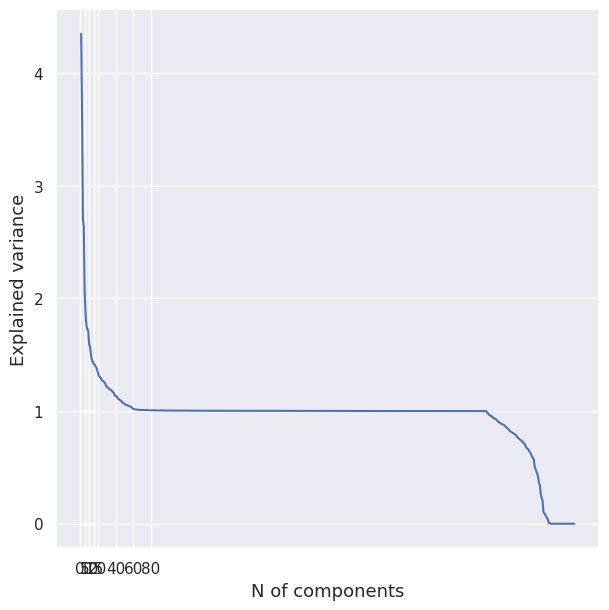

In [46]:


# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(x_cols)

# Compute the explained variance by component
explained_variance = pca.explained_variance_

# Plot explained variance
# Get the number of components from the PCA model
n_components = pca.n_components_
fig = plt.figure(figsize=(7,7))
# Use n_components to create the x-axis values
plt.plot(np.arange(1, n_components + 1, 1), explained_variance)
plt.xlabel('N of components', fontsize=13)
plt.ylabel('Explained variance', fontsize=13)
plt.xticks([0,5,10,15,20,40,60,80])
plt.show()

In [47]:
# Initializes PCA with the 3 components

pca = PCA(n_components=3)
x_3cols = pca.fit_transform(x_cols)

In [48]:
# Creates empty list to store inertia values
iner = []

# Calculates inertia for the number of clusters selected
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(x_3cols)
    iner.append(kmeans.inertia_)

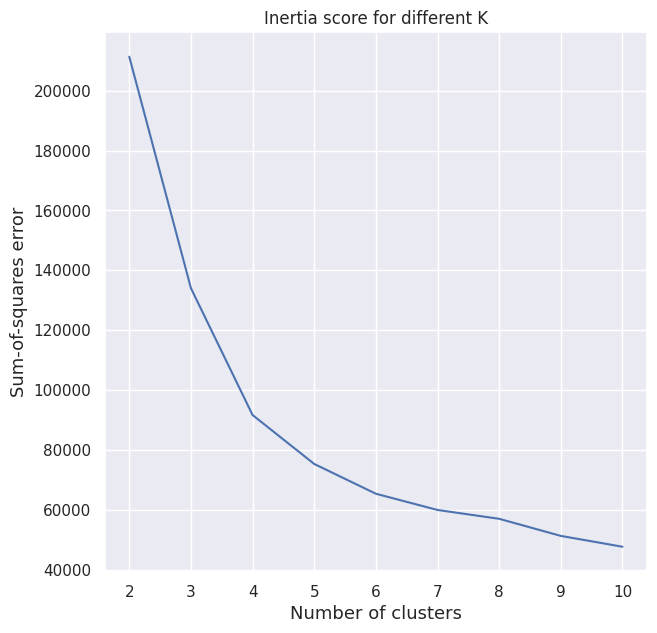

In [49]:
# Creates x axis for the plot with number of clusters
xs = np.arange(2, 11, 1)

# Creates figure and plot
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.plot(xs, iner)
ax1.set_title('Inertia score for different K')
ax1.set_xlabel('Number of clusters', fontsize=13)
ax1.set_xticks([2,3,4,5,6,7,8,9,10])
ax1.set_ylabel('Sum-of-squares error', fontsize=13)

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.39217627523544085
For n_clusters = 3 The average silhouette_score is : 0.43350632122398775
For n_clusters = 4 The average silhouette_score is : 0.45097366266967226
For n_clusters = 5 The average silhouette_score is : 0.4390472357953335
For n_clusters = 6 The average silhouette_score is : 0.337185011813483
For n_clusters = 7 The average silhouette_score is : 0.3188723358041351


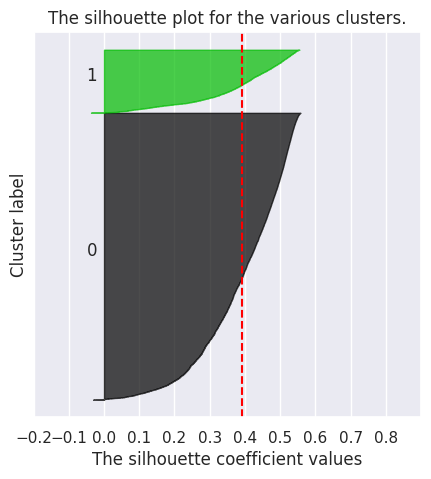

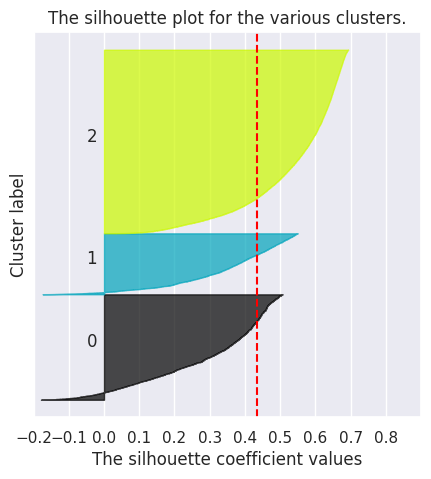

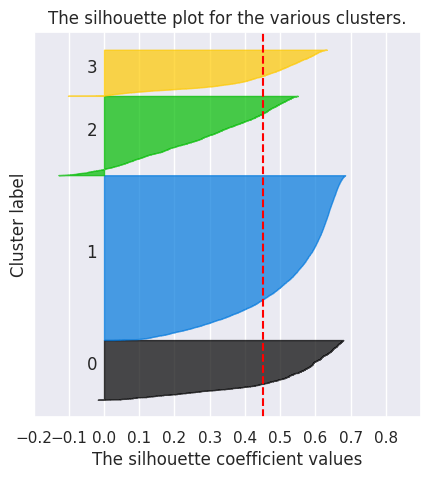

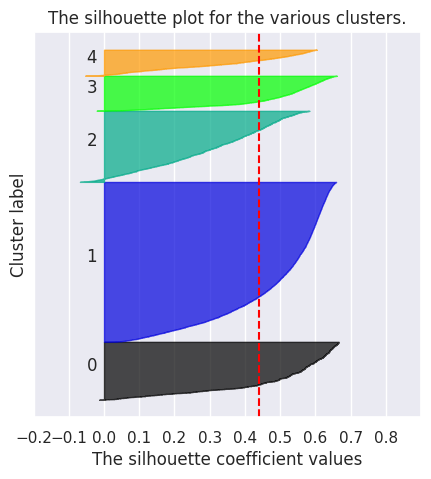

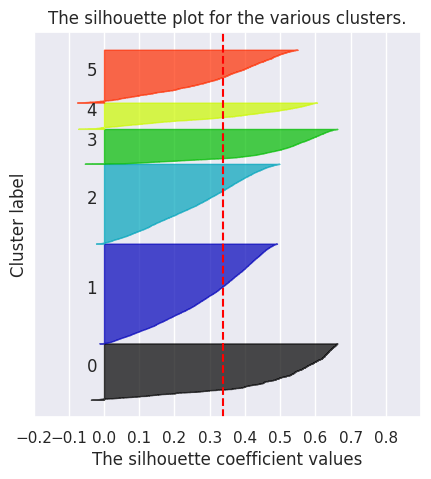

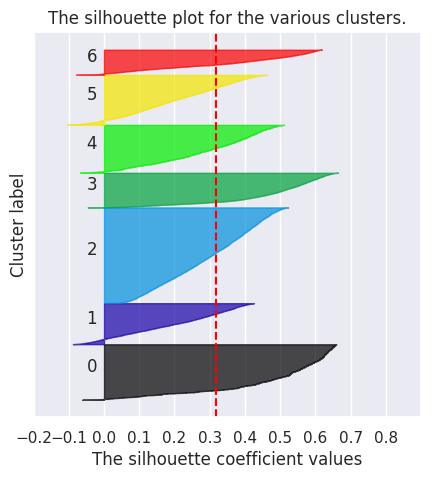

In [50]:
# Selects the number of clusters to test
range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(figsize=(5,5))

    # The silhouette coefficient can range from -1, 1 but in this case all lie within [-0.2, 0.9]
    ax1.set_xlim([-0.2, 0.9])
    ax1.margins(0.05)

    # Initialize the clusterer with n_clusters value and a random generator seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_3cols)

    # The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_3cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_3cols, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

plt.show()

In [51]:
t_sne = TSNE(learning_rate=5, n_jobs=-1)
transformed = t_sne.fit_transform(x_3cols)
xs = transformed[:,0]
ys = transformed[:,1]

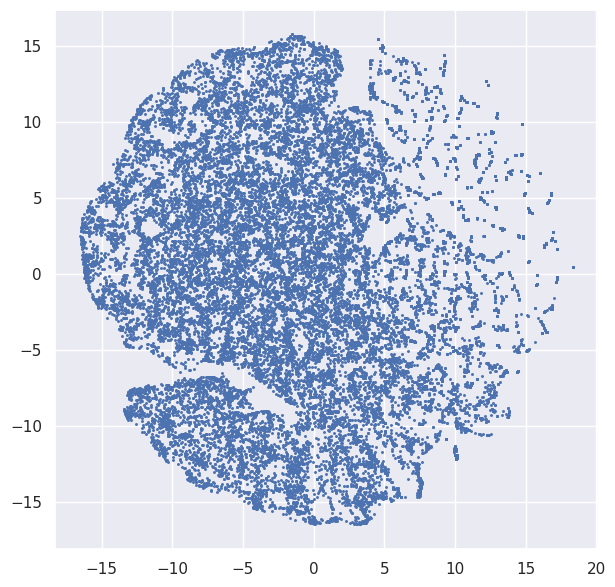

In [52]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(xs, ys, s=5, marker='.')
plt.show()

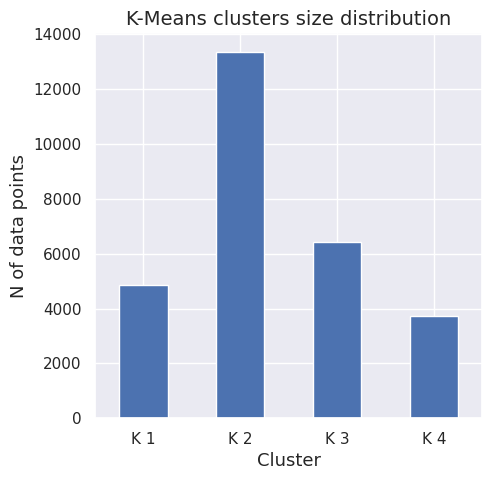

In [53]:
# Initializes the model with selected K, fit and predict the labels for the dataset
kmeans = KMeans(n_clusters=4, random_state=42).fit(x_3cols)
labels_km = kmeans.predict(x_3cols)

# Creates dataframe with the labels
kmeans_df = pd.DataFrame(labels_km, columns=['cluster_id'])

# Create plot
fig = plt.figure(figsize=(5, 5))
kmeans_df.value_counts().sort_index().plot.bar()
plt.xlabel('Cluster', fontsize=13)
plt.title('K-Means clusters size distribution', fontsize=14)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

In [54]:
# Calculates average silhouette score for 4 clusters
from sklearn.metrics import silhouette_score # Import the silhouette_score function
silhouette_km = silhouette_score(x_3cols, labels_km)
print('The Silhouette coefficient for the K-Means Clustering algorithm is '+str(round(silhouette_km, 2)))

The Silhouette coefficient for the K-Means Clustering algorithm is 0.45


In [55]:
# Initializes and predicts labels
ac_labels = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_ac = silhouette_score(x_3cols, ac_labels)
# Creates dataframe of the labels for later use
agglo_df = pd.DataFrame(ac_labels, columns=['cluster_id'])

The Silhouette coefficient for the Agglomerative Hierarchical Clustering algorithm is 0.44


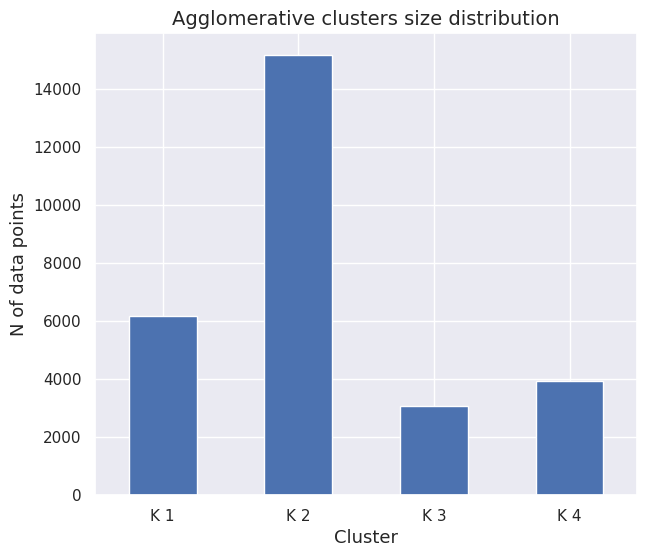

In [56]:
print('The Silhouette coefficient for the Agglomerative Hierarchical Clustering algorithm is '+str(round(silhouette_ac, 2)))

# Creates plot of cluster sizes
agglo_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('Agglomerative clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

In [57]:
# Initializes and predicts labels
db_labels = DBSCAN(eps=1).fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_db = silhouette_score(x_3cols, db_labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
# Creates dataframe of the labels for later use
dbscan_df = pd.DataFrame(db_labels, columns=['cluster_id'])

The number of clusters detected by the DBSCAN algorithm is 2
The Silhouette coefficient for the DBSCAN algorithm is 0.25


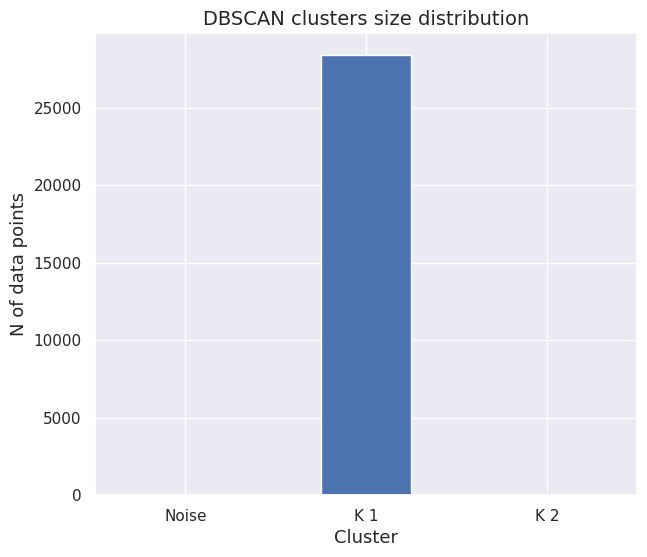

In [59]:
print('The number of clusters detected by the DBSCAN algorithm is '+str(n_clusters_))
print('The Silhouette coefficient for the DBSCAN algorithm is '+str(round(silhouette_db, 2)))

# Creates plot of cluster sizes
dbscan_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('DBSCAN clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
# Dynamically create labels based on the number of clusters detected
labels = ['Noise'] + [f'K {i}' for i in range(1, n_clusters_ + 1)]
plt.xticks(ticks=range(0,(n_clusters_+1)), labels=labels, rotation=0)

plt.show()

In [60]:
# Estimates bandwidth for MeanShift algorithm
bandwidth = estimate_bandwidth(x_3cols, quantile=0.3, n_jobs=-1)

# Initializes and predicts labels
ms_labels = MeanShift(bandwidth=bandwidth).fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_ms = silhouette_score(x_3cols, ms_labels)

# Calculates number of clusters
n_clusters_ = len(set(ms_labels))

# Creates dataframe of the labels for later use
meansh_df = pd.DataFrame(ms_labels, columns=['cluster_id'])

The estimated bandwidth is 3.14
The number of clusters detected by the MeanShift algorithm is 2
The Silhouette coefficient for the MeanShift algorithm is 0.38


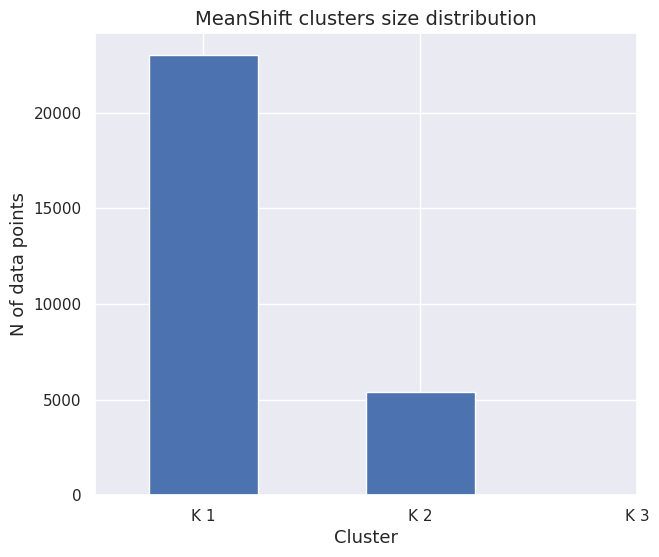

In [61]:
print('The estimated bandwidth is '+str(round(bandwidth, 2)))
print('The number of clusters detected by the MeanShift algorithm is '+str(n_clusters_))
print('The Silhouette coefficient for the MeanShift algorithm is '+str(round(silhouette_ms, 2)))

# Creates plot of cluster sizes
meansh_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('MeanShift clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2], labels=['K 1','K 2','K 3'], rotation=0)

plt.show()

In [62]:
# Initializes and predicts labels
gm_labels = GaussianMixture(n_components=4, covariance_type='full').fit_predict(x_3cols)
# Calculates average silhouette coefficient
silhouette_gm = silhouette_score(x_3cols, gm_labels)
# Creates dataframe of the labels for later use
gaussmix_df = pd.DataFrame(gm_labels, columns=['cluster_id'])

The Silhouette coefficient for the EM Clustering algorithm is 0.43


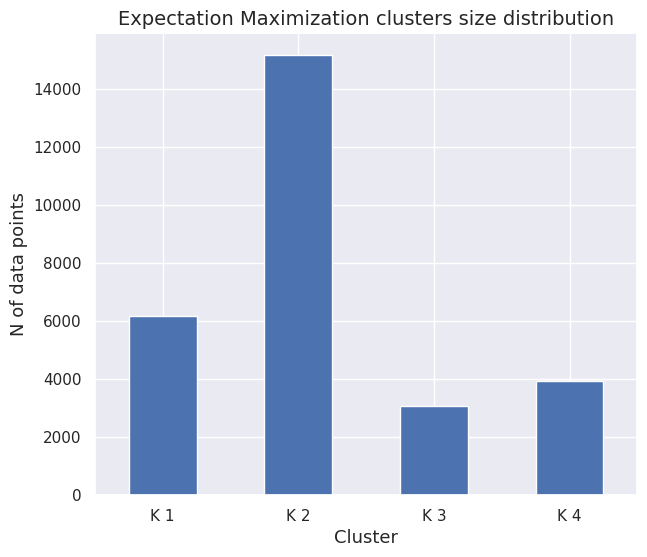

In [63]:
print('The Silhouette coefficient for the EM Clustering algorithm is '+str(round(silhouette_gm, 2)))

# Creates plot of cluster sizes
agglo_df.value_counts().sort_index().plot.bar(figsize=(7, 6))
plt.title('Expectation Maximization clusters size distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('N of data points', fontsize=13)
plt.xticks(ticks=[0,1,2,3], labels=['K 1','K 2','K 3','K 4'], rotation=0)
plt.show()

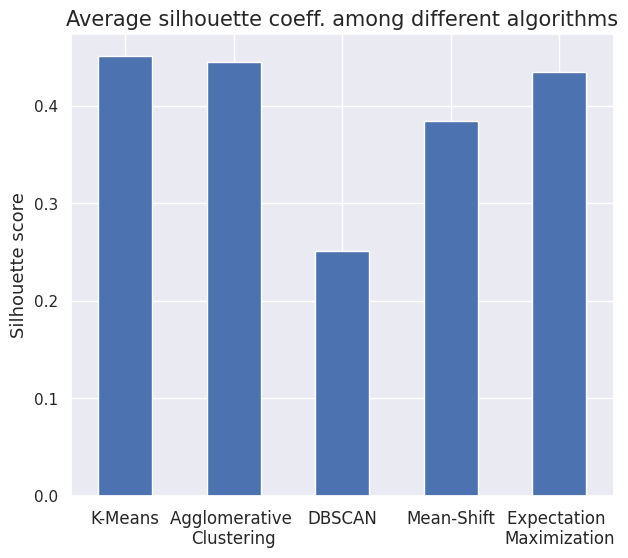

In [64]:
# Create df with results
algorithms = ['K-Means', 'Agglomerative \nClustering', 'DBSCAN', 'Mean-Shift', 'Expectation \nMaximization']
scores = [silhouette_km, silhouette_ac, silhouette_db, silhouette_ms, silhouette_gm]
algorithm_test = pd.DataFrame({'algorithm':algorithms, 'silhouette_score':scores})

# Plot results
algorithm_test.plot.bar(legend=None, figsize=(7, 6))
plt.ylabel('Silhouette score', fontsize=13)
plt.title('Average silhouette coeff. among different algorithms', fontsize=15)
plt.xticks(ticks=[0,1,2,3,4], labels=algorithms, rotation=0, fontsize=12)

plt.show()

In [65]:
# Initialize the pca with 2 components and fit and transform the original dataset
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_cols)

# Create df with the principal components and assign column names
pca_df = pd.DataFrame(x_new, columns=['x', 'y'])

# Joins labels to 2-component dataset
customer_seg = kmeans_df.join(pca_df)

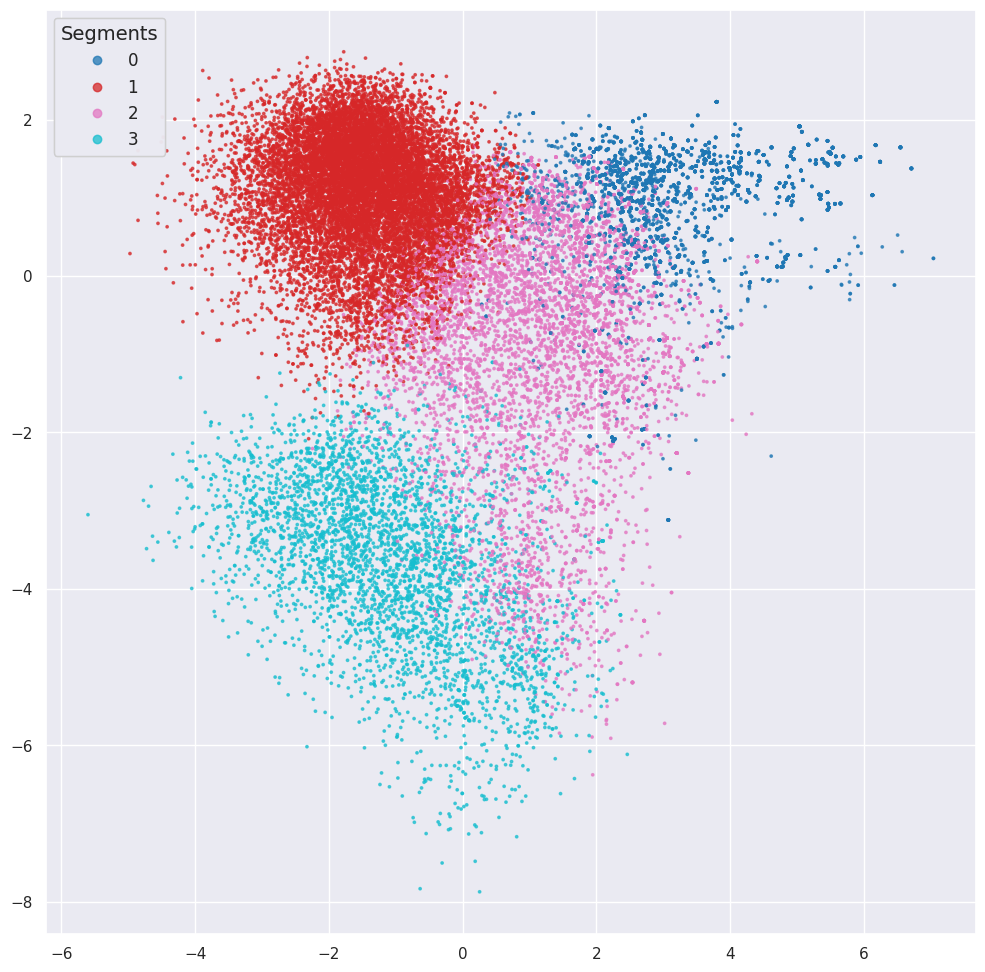

In [66]:
# Creates plot
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter('x', 'y', c='cluster_id', data=customer_seg, alpha=0.7, s=3, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Segments", fontsize=12, title_fontsize=14)
ax.add_artist(legend)

plt.show()

In [68]:
# Reset index in original dataset
dfo.reset_index(inplace=True)
# Drop 'level_0' instead of 'index' if 'index' was an existing column
dfo.drop(['level_0'], axis=1, inplace=True, errors='ignore')
# errors='ignore' prevents an error if 'level_0' doesn't exist

# Adds cluster labels to original dataset
dfo_cat_labeled = dfo.select_dtypes(exclude='float64').join(kmeans_df)
dfo_num_labeled = dfo.select_dtypes(include='float64').join(kmeans_df)

In [69]:
# Group observations by cluster label and aggregate for most common value in categories
segments_df_cat = dfo_cat_labeled.groupby(by='cluster_id').agg(lambda x:x.value_counts().index[0])

# Group observations by cluster label and aggregate for mean value in numerical columns
segments_df_num = dfo_num_labeled.groupby(by='cluster_id').median()

In [70]:
# Shows categorical attributes per segment
segments_df_cat.T

cluster_id,0,1,2,3
index,2,3,1,0
hotel,City Hotel,City Hotel,City Hotel,Resort Hotel
lead_time,304,0,0,0
arrival_date_month,September,August,October,August
stays_in_weekend_nights,0,2,0,0
stays_in_week_nights,2,2,1,1
meal,BB,BB,BB,BB
country,National,Other_Europe,National,National
market_segment,Groups,Online TA,Offline TA/TO,Direct
distribution_channel,TA/TO,TA/TO,TA/TO,Direct


In [71]:
# shows numerical attributes per segment
segments_df_num.T

cluster_id,0,1,2,3
allyear,2019.0,2019.0,2019.0,2019.0
adults,2.0,2.0,2.0,2.0
children,0.0,0.0,0.0,0.0
babies,0.0,0.0,0.0,0.0
is_repeated_guest,0.0,0.0,0.0,0.0
previous_cancellations,0.0,0.0,0.0,0.0
previous_bookings_not_canceled,0.0,0.0,0.0,0.0
adr,76.5,107.0,75.0,95.0
required_car_parking_spaces,0.0,0.0,0.0,0.0
CheckOutDate,NaN,NaN,NaN,NaN
